In [1]:
import h5py
import numpy as np
import collections
import matplotlib.pylab as plt
import pickle
from tqdm import tqdm, trange
from skimage.color import rgb2hed
from sklearn.datasets import make_classification
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

In [2]:
D = h5py.File('breast.h5', 'r')
X,Y,P = D['images'], np.array(D['counts']), np.array(D['id'])
print(len(X), len(Y), len(P))

7404 7404 7404


Split training data and testing data: Use data from patient IDs 1-13 for training and cross validation and 14-18 for testing. 

In [3]:
for items in P:
    if items == 14:
        index = list(P).index(items)
        break
print(index)

5841


In [4]:
Xtrain, Ytrain, Ptrain = X[:index], Y[:index], P[:index]  #Training data with: Image, Count, ID
Xtest, Ytest, Ptest = X[index:], Y[index:], P[index:]

In [5]:
print(Ytrain.shape)

(5841,)


# **Question1**

**i. How many training and test examples are there?**

In [12]:
print('Length of training data: ', len(Xtrain))
print('Length of testing data:  ', len(Xtest))

Length of training data:  5841
Length of testing data:   1563


**ii. Show some image examples using plt.imshow. Describe your observations on what you see in the images and how it correlates with the cell count (target variable).**  <br>

As it has been shown below, four images are chosen as example. Visually, we can count the number of lymphocytes based on the cells with darker color. And this number corresponds to the output of P\[train\]. Therefore, the cell count represents the number of lymphocytes in an image. 

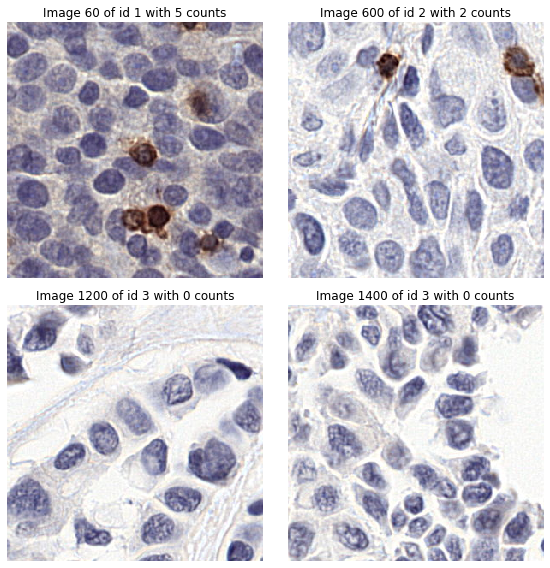

In [6]:
fig,axes = plt.subplots(2,2,figsize=(8,8))
ax = axes.ravel()

ax[0].imshow(Xtrain[60])
ax[0].set_title('Image 60 of id %d with %d counts'%(Ptrain[60], Ytrain[60]))

ax[1].imshow(Xtrain[600])
ax[1].set_title('Image 600 of id %d with %d counts'%(Ptrain[600], Ytrain[600]))

ax[2].imshow(Xtrain[1200])
ax[2].set_title('Image 1200 of id %d with %d counts'%(Ptrain[1200], Ytrain[1200]))

ax[3].imshow(Xtrain[1400])
ax[3].set_title('Image 1400 of id %d with %d counts'%(Ptrain[1400], Ytrain[1400]))

for a in ax.ravel():
  a.axis('off')

fig.tight_layout()

**iv. Pre-processing: Convert and view a few images from RGB space to HED space and show the D channel which should identify  the brown elements in the image. For this purpose, you can use the color separation notebook available here: https://scikitimage.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html**

In [0]:
# Create an artificial color close to the original one
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])

Example: this is the first image which has been converted from RGB space to HED space, and the bottom right image displays the D channel which identifies the brown elements in the image.

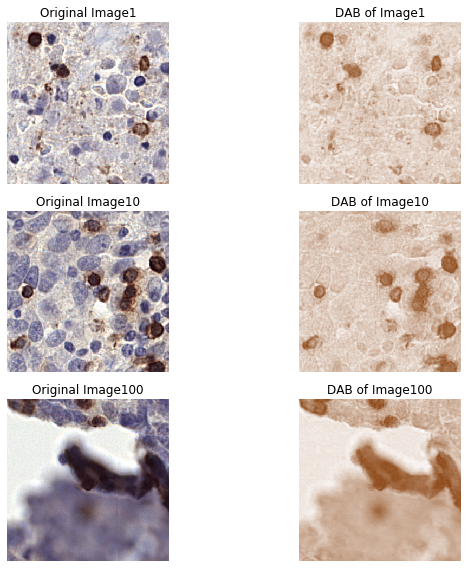

In [0]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=True)
ax = axes.ravel()

ihc_hed1 = rgb2hed(Xtrain[1])
ax[0].imshow(Xtrain[1])
ax[0].set_title("Original Image1")

ax[1].imshow(ihc_hed1[:, :, 2], cmap=cmap_dab)
ax[1].set_title("DAB of Image1")

ihc_hed2 = rgb2hed(Xtrain[10])
ax[2].imshow(Xtrain[10])
ax[2].set_title("Original Image10")

ax[3].imshow(ihc_hed2[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB of Image10")

ihc_hed3 = rgb2hed(Xtrain[100])
ax[4].imshow(Xtrain[100])
ax[4].set_title("Original Image100")

ax[5].imshow(ihc_hed3[:, :, 2], cmap=cmap_dab)
ax[5].set_title("DAB of Image100")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

**v. Do a scatter plot of the average of the brown channel for each image vs. its cell count. Do you think this feature would be useful in your regression model? Explain your reasoning.**  <br>

According to the scatter plot which shows the relationship betwenen two sets of data, I think the average of the brown channel for each image is positive correlated with the number of cells (lymphocytes). The reason is all the datapoints in this plot are concentrated in the half bottom of the image and this can strongly support the conclusion that these two sets are correlated.

In [7]:
average_brown = []
for image in tqdm(Xtrain):
  ihc_hed = rgb2hed(image)
  average_brown.append(np.mean(ihc_hed[:, :, 2]))

for image in tqdm(Xtest):
  ihc_hed = rgb2hed(image)
  average_brown.append(np.mean(ihc_hed[:, :, 2]))

100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:09<00:00, 172.87it/s]


In [13]:
with open('average_brown.pickle', 'rb') as file:
    average_brown = pickle.load(file)

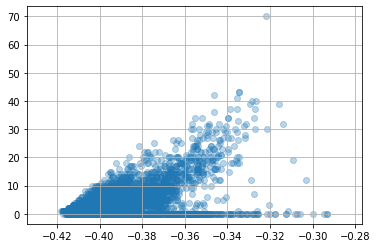

In [8]:
plt.grid()
plt.scatter(average_brown,Y,alpha=0.3)
plt.show()

**vi. What is the number of images for each patient? Do you think this can have an impact on your regression model?** <br>

The number of images for each patient are displayed below. Meanwhile, I think the number of images of each patient do not have impact on future regression model. The reason is, the input variables are the features extracted from each image (eg. average, variance, entropy of each image) and we use these variables to fit the regression model which outputs the predicted counts of cells in each image. Therefore, in the process of regression, we won't take the number of images into consideration and this number is independent on our dataset.

In [11]:
id = 0
index = 0
count = []
for id in range(1,14):
  n = 0 
  for items in P:
    if items == id:
      n += 1
  count.append(n)
print("A list which contains the number of images for each patient: ", count)

A list which contains the number of images for each patient:  [320, 465, 958, 192, 44, 105, 83, 632, 533, 552, 761, 791, 405]


**vii. What performance metrics can you use for this purpose? Which one will be the best performance metric for this problem? Please give reasoning.** <br>

Generally, there are mainly three types of performance metrics that would be taken in consideration when it comes to regression: Mean Squared Error, Correlation Coefficient and R squared. In this situation, RMSE will be chosen to be the best performance metric because it can better interpret the data. Besides, as for the correlation coefficient, it can only be used when variables are measurable in one scale. As for R-squared, it cannot be used to determine whether the coefficient estimates and predictions are biased or not.

# **Question2**
**2.1 Extract features from a given image.**


In [5]:
brown_channel = []
red_channel = []
green_channel = []
blue_channel = []

for image in tqdm(Xtrain):
    brown = rgb2hed(image)[:, :, 2]
    brown_channel.append(brown)

    red = image[:, :, 2]
    red_channel.append(red)

    green = image[:, :, 1]
    green_channel.append(green)

    blue = image[:, :, 0]
    blue_channel.append(blue)

for image in tqdm(Xtest):
    brown = rgb2hed(image)[:, :, 2]
    brown_channel.append(brown)

    red = image[:, :, 2]
    red_channel.append(red)

    green = image[:, :, 1]
    green_channel.append(green)

    blue = image[:, :, 0]
    blue_channel.append(blue)

100%|█████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:10<00:00, 154.49it/s]


In [2]:
with open('brown_channel.pickle', 'rb') as file:
    brown_channel = pickle.load(file)
    
with open('red_channel.pickle', 'rb') as file:
    red_channel = pickle.load(file)

with open('green_channel.pickle', 'rb') as file:
    green_channel = pickle.load(file)

with open('blue_channel.pickle', 'rb') as file:
    blue_channel = pickle.load(file)

**a. Calculate the average of the “brown”, red, green and blue channels**

In [10]:
average_red = []
average_green = []
average_blue = []

for r_i in red_channel:
    average_red.append(np.mean(r_i))

for g_i in green_channel:
    average_green.append(np.mean(g_i))
    
for b_i in blue_channel:
    average_blue.append(np.mean(b_i))

In [11]:
print("Average of brown channel: ", average_brown)
print()
print("Average of red channel: ", average_red)
print()
print("Average of green channe: ", average_green)
print()
print("Average of blue channel: ", average_blue)

Average of brown channel:  [-0.3799775017875077, -0.38154091969890447, -0.36659552452338035, -0.37877591559484897, -0.3817877483512697, -0.38077478899629236, -0.34497727180433535, -0.3735007993029795, -0.3771023112997314, -0.3877012996399401, -0.3694625873379001, -0.3686623553261842, -0.36896454061038536, -0.373330084124114, -0.3668341028651476, -0.3774372033916763, -0.4064790004074735, -0.34723401420898764, -0.3784335213844399, -0.38148066014967974, -0.35076728196359697, -0.41402199542212226, -0.37831079037930615, -0.3737456204571334, -0.3717041337298681, -0.3763684764743452, -0.36227949664434456, -0.3854781776795987, -0.38036111757415936, -0.33544196675036814, -0.370787175991583, -0.37101807572860185, -0.38009301168968024, -0.37874774317613336, -0.3682418917158904, -0.37269311122506216, -0.38059590124612647, -0.36365428597047883, -0.3564529074037676, -0.3496913452393351, -0.3741605045508346, -0.3717079148603698, -0.37711694529206774, -0.4048551690795206, -0.3744526300575336, -0.38111

In [12]:
print('Correlation coefficient of average of brown channel and cell count: %f' %pearsonr(average_brown,Y)[0])
print()
print('Correlation coefficient of average of red channel and cell count: %f' %pearsonr(average_red,Y)[0])
print()
print('Correlation coefficient of average of green channel and cell count: %f' %pearsonr(average_green,Y)[0])
print()
print('Correlation coefficient of average of blue channel and cell count: %f' %pearsonr(average_blue,Y)[0])

Correlation coefficient of average of brown channel and cell count: 0.592591

Correlation coefficient of average of red channel and cell count: -0.538740

Correlation coefficient of average of green channel and cell count: -0.478590

Correlation coefficient of average of blue channel and cell count: -0.416976


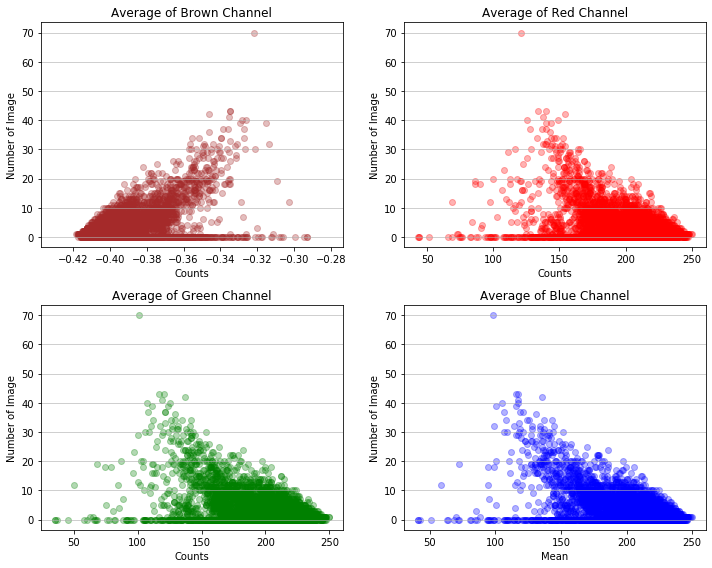

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.subplot(221)
plt.scatter(average_brown,Y,alpha=0.3,c='brown')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Average of Brown Channel")

plt.subplot(222)
plt.scatter(average_red,Y,alpha=0.3,c='red',label='average of red channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Average of Red Channel")

plt.subplot(223)
plt.scatter(average_green,Y,alpha=0.3,c='green',label='average of green channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Average of Green Channel")

plt.subplot(224)
plt.scatter(average_blue,Y,alpha=0.3,c='blue',label='average of blue channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mean')
plt.ylabel('Number of Image')
plt.title("Average of Blue Channel")

fig.tight_layout()

**b. Calculate the variance of the “brown”, red, green and blue channels**


In [13]:
var_brown = []
var_red = []
var_green = []
var_blue = []

for b_i in brown_channel:
  var_brown.append(np.var(b_i))

for r_i in red_channel:
  var_red.append(np.var(r_i))

for g_i in green_channel:
  var_green.append(np.var(g_i))

for b_i in blue_channel:
  var_blue.append(np.var(b_i))

In [14]:
print('Variance of brown channels:', var_brown)
print()
print('Variance of red channels:', var_red)
print()
print('Variance of green channels:', var_green)
print()
print('Variance of blue channels:', var_blue)

Variance of brown channels: [0.0005931334288957775, 0.0005319994945645943, 0.0008929976864749479, 0.0006265878797806634, 0.0006031294529867265, 0.0005745534754154522, 0.0025758682119222886, 0.0008315043596225408, 0.0010235660603830287, 0.0002873788518494738, 0.0008524537822079935, 0.0002378764070530083, 0.0007887380618988935, 0.0009432612656220495, 0.0009836171295056649, 0.00045990929584506735, 0.00016330709624614296, 0.0015612694609054255, 0.0006898425028164764, 0.0006243304748277811, 0.0012328125844259263, 2.2054996243185203e-05, 0.0008125109331237168, 0.0005080814845505724, 0.00026910097344737564, 0.0015312981794854315, 0.0015703783932280299, 0.0005786077867108399, 0.0006341622200012492, 0.0013632558084690075, 0.0006230341407271395, 0.0005916198183834596, 0.0006264517968134673, 0.0008739255152809159, 0.0007993441453532356, 0.00113450943878734, 0.0005387018478332253, 0.0008999365840255974, 0.0006539092199300769, 0.0023493566663203365, 0.0010368609872079295, 0.00021489847246765247, 0.

In [22]:
print('Correlation coefficient of variance of brown channel and cell count: %f ' %pearsonr(var_brown,Y)[0])
print()
print('Correlation coefficient of variance red channel and cell count: %f' %pearsonr(var_red,Y)[0])
print()
print('Correlation coefficient of variance green channel and cell count: %f' %pearsonr(var_green,Y)[0])
print()
print('Correlation coefficient of variance blue channel and cell count: %f' %pearsonr(var_blue,Y)[0])

Correlation coefficient of variance of brown channel and cell count: 0.437211 

Correlation coefficient of variance red channel and cell count: 0.152620

Correlation coefficient of variance green channel and cell count: 0.242559

Correlation coefficient of variance blue channel and cell count: 0.309844


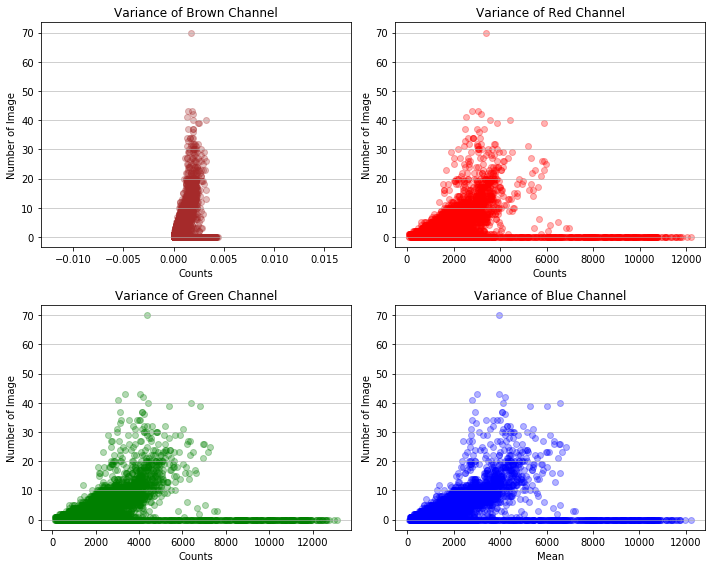

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.subplot(221)
plt.scatter(var_brown,Y,alpha=0.3,c='brown')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Variance of Brown Channel")

plt.subplot(222)
plt.scatter(var_red,Y,alpha=0.3,c='red',label='average of red channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Variance of Red Channel")

plt.subplot(223)
plt.scatter(var_green,Y,alpha=0.3,c='green',label='average of green channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Variance of Green Channel")

plt.subplot(224)
plt.scatter(var_blue,Y,alpha=0.3,c='blue',label='average of blue channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mean')
plt.ylabel('Number of Image')
plt.title("Variance of Blue Channel")

fig.tight_layout()

**c. Calculate the entropy of the “brown”, red, green and blue channels**

In [15]:
from scipy.stats import entropy

def ent(label, base=None):
    value,count = np.unique(label, return_counts=True)
    return entropy(count, base=None)

In [16]:
entropy_brown = []
entropy_red = []
entropy_green = []
entropy_blue = []

for b_i in tqdm(brown_channel):
  entropy_brown.append(ent(b_i,base=None))

for r_i in tqdm(red_channel):
  entropy_red.append(ent(r_i,base=None))

for g_i in tqdm(green_channel):
  entropy_green.append(ent(g_i,base=None))

for b_i in tqdm(blue_channel):
  entropy_blue.append(ent(b_i,base=None))

100%|█████████████████████████████████████████████████████████████████████████████| 7404/7404 [00:19<00:00, 376.59it/s]


In [17]:
print('Entropy of brown channels:', entropy_brown)
print('Entropy of red channels:', entropy_red)
print('Entropy of green channels:', entropy_green)
print('Entropy of blue channels:', entropy_blue)

Entropy of brown channels: [9.849427145101561, 9.828835326754453, 10.201450845625963, 9.857882130295716, 9.707137044379348, 9.668189582245455, 9.593364161725876, 9.884874025783631, 10.004232382711795, 9.615550194137015, 10.118719309357884, 9.479754990150317, 10.116505667481297, 10.023847502992583, 10.26502923818421, 9.817101052904311, 8.86212423475065, 10.308467292669157, 9.832031668530666, 9.981871931033744, 10.228630139012317, 5.856319607288584, 10.036253207537419, 9.756050427926457, 9.583152405184173, 9.730701380777406, 10.146975202896064, 9.718519181989356, 9.78260212994514, 10.331489805735856, 9.950666342125736, 9.932068189545642, 10.012359920177484, 10.207801381188334, 10.075986922595051, 9.89232167551101, 9.922265374183976, 10.15141100417296, 9.475335229728834, 9.905875724030338, 10.144063685584701, 9.551598880385125, 10.149908259758906, 7.982685011560017, 9.99790889745318, 9.772043239978998, 10.317994736999594, 9.920110621041337, 10.25890609930899, 10.12002898500752, 9.86753071

In [29]:
print('Correlation coefficient of entropy of brown and cell count: %f' %pearsonr(entropy_brown,Y)[0])
print()
print('Correlation coefficient of entropy pf red channel and cell count: %f' %pearsonr(entropy_red,Y)[0])
print()
print('Correlation coefficient of entropy of green channel and cell count: %f' %pearsonr(entropy_green,Y)[0])
print()
print('Correlation coefficient of entropy of blue channel and cell count: %f' %pearsonr(entropy_blue,Y)[0])

Correlation coefficient of entropy of brown and cell count: 0.453804

Correlation coefficient of entropy pf red channel and cell count: 0.412670

Correlation coefficient of entropy of green channel and cell count: 0.441952

Correlation coefficient of entropy of blue channel and cell count: 0.509974


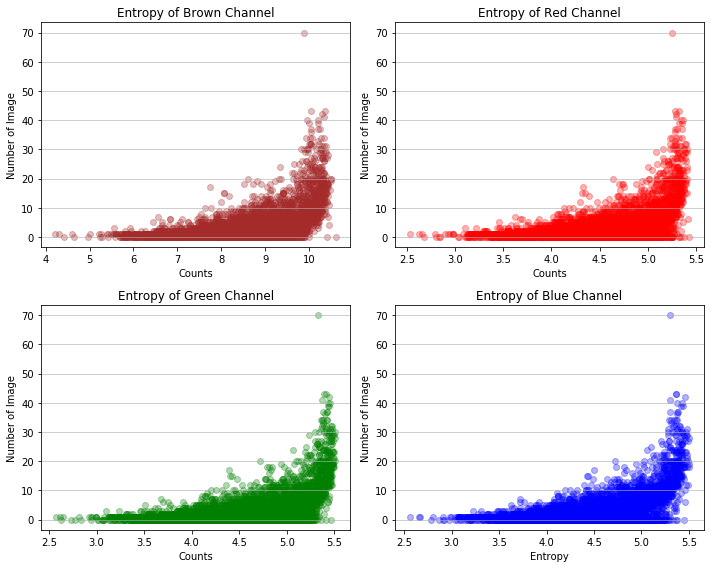

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.subplot(221)
plt.scatter(entropy_brown,Y,alpha=0.3,c='brown')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Entropy of Brown Channel")

plt.subplot(222)
plt.scatter(entropy_red,Y,alpha=0.3,c='red',label='entropy of red channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Entropy of Red Channel")

plt.subplot(223)
plt.scatter(entropy_green,Y,alpha=0.3,c='green',label='entropy of green channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Counts')
plt.ylabel('Number of Image')
plt.title("Entropy of Green Channel")

plt.subplot(224)
plt.scatter(entropy_blue,Y,alpha=0.3,c='blue',label='entropy of blue channel')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Entropy')
plt.ylabel('Number of Image')
plt.title("Entropy of Blue Channel")

fig.tight_layout()

**d. Histogram of each channel** <br>

Here, we only extract one image (image 100) to plot its corresponding histogram with respect to brown, red, green, blue channels. 

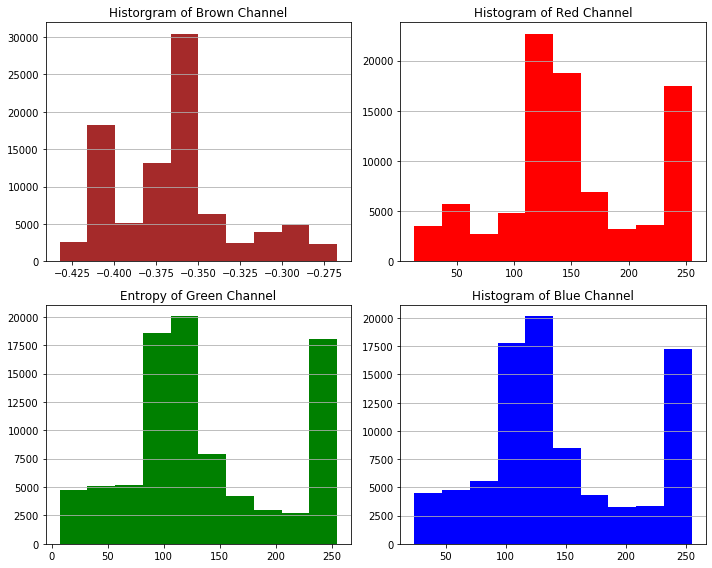

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.subplot(221)
plt.hist(brown_channel[100].flatten(), color='brown')
plt.grid(axis='y')
plt.title("Historgram of Brown Channel")

plt.subplot(222)
plt.hist(red_channel[100].flatten(), color='red')
plt.grid(axis='y')
plt.title("Histogram of Red Channel")

plt.subplot(223)
plt.hist(green_channel[100].flatten(), color='green')
plt.grid(axis='y')
plt.title("Entropy of Green Channel")

plt.subplot(224)
plt.hist(blue_channel[100].flatten(), color='blue')
plt.grid(axis='y')
plt.title("Histogram of Blue Channel")

fig.tight_layout()

**e. PCA Coefficients (you may want to use randomized PCA or incremental PCA, see: https://scikitlearn.org/stable/modules/generated/sklearn.decomposition.PCA.html)**

In [5]:
from sklearn.decomposition import IncrementalPCA

ipca_flat = []
for image in tqdm(Xtrain):
    ipca_flat.append(image.flatten())

ipca_flat = np.array(ipca_flat)  # Convert into a 1d array

100%|████████████████████████████████████████████████████████████████████████████| 5841/5841 [00:00<00:00, 9182.57it/s]


In [8]:
ipca = IncrementalPCA(n_components=1, batch_size=200)
ipc = ipca.fit_transform(ipca_flat)  # Incremental Principal Components
ipca_coefficient = np.corrcoef(np.hstack(ipc), Ytrain)

Incremental PCA Coefficient is  -0.4338752845882729


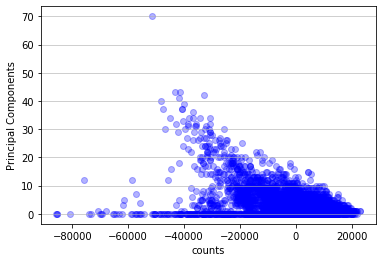

In [11]:
plt.scatter(ipc,Ytrain,alpha=0.3,c='blue')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('counts')
plt.ylabel('Principal Components')
print("Incremental PCA Coefficient is ", ipca_coefficient[0][1])

**f. Any other features that you think can be useful for this work. Describe your reasoning for using these features.**

**Plot the scatter plot and calculate the correlation coefficient of each feature you obtain vs. the target variable (cell count) across all images. Which features do you think are important? Give your reasoning.** <br>

Outputs of each model are listed below. <br>

From my perspective, entropy and PCA coefficients are of vital importance in this task. Firstly, entropy represents the information of each pixel value in its channel. In other words, it is used to describe the corresponding states of intensity level which individual pixels can adapt. Therefore, it can provide better comparison with other images. <br>

As for PCA coefficients, since PCA is used to reduce the dimensionality. 

**2.2 Extract features from a given image.** <br>

In [25]:
dataset = []

for i in trange(len(Y)):
    dataset.append([average_brown[i],
                   average_red[i],
                   average_green[i],
                   average_blue[i],
                   var_brown[i],
                   var_red[i],
                   var_green[i],
                   var_blue[i],
                   entropy_brown[i],
                   entropy_red[i],
                   entropy_green[i],
                   entropy_blue[i]])

train_dataset = dataset[:index]
test_dataset = dataset[index:]

100%|██████████████████████████████████████████████████████████████████████████| 7404/7404 [00:00<00:00, 441681.51it/s]


In [26]:
with open("train_dataset.pickle", "wb") as file:
  pickle.dump(train_dataset, file)

with open("test_dataset.pickle", "wb") as file:
  pickle.dump(test_dataset, file)  

In [6]:
with open("train_dataset.pickle","rb") as file:
    train_dataset = pickle.load(file)    

with open("test_dataset.pickle","rb") as file:
    test_dataset = pickle.load(file)    

In [7]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.model_selection import cross_val_score
import pandas as pd

In [8]:
def scatter_plot(Xtest, Ytest, model):

    Y_pred = model.predict(Xtest)
    Y_pred = Y_pred.flatten()
    
    model_corr = np.corrcoef(Ytest, Y_pred)[0,1]
    model_rmse = sqrt(mean_squared_error(Ytest, Y_pred))
    model_r2 = r2_score(Ytest, Y_pred)
    
    print('Correlation Coefficient: ', round(model_corr, 4))
    print('Root Mean Squared Error: ', round(model_rmse, 4))
    print('R2 score: ', round(model_r2, 4))
    
    plt.scatter(Ytest, Y_pred, alpha=0.3)
    
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title("Scatter Plot between Y_true and Y_predict")
    

In [9]:
train_dataset = np.array(train_dataset)
test_dataset = np.array(test_dataset)

2.2.1 Ordinary Least Squares (OLS) regression 

RMSE of 3-fold cross-validation is:  [3.5436, 3.8516, 2.1581]

Correlation Coefficient:  0.7418
Root Mean Squared Error:  3.9041
R2 score:  0.4192


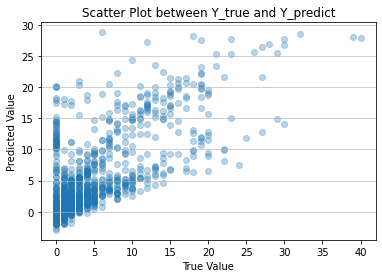

In [10]:
model_ols = LinearRegression(fit_intercept = True)
model_ols.fit(train_dataset, Ytrain)

rmse_ols = [round(sqrt(i),4) for i in -cross_val_score(model_ols, train_dataset, Ytrain, cv=3, scoring='neg_mean_squared_error')]
print('RMSE of 3-fold cross-validation is: ', rmse_ols)
print()

scatter_plot(test_dataset, Ytest, model_ols)

2.2.2 Multilayer Perceptron

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from tensorflow import keras
from keras.optimizers import Adagrad
from keras import backend
from keras import initializers
from keras.models import * 
from keras.layers import * 
from keras.wrappers.scikit_learn import KerasRegressor

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def Multilayer_Perceptron():
    model= Sequential()
    model.add(Dense(units=36, input_dim = 12, kernel_initializer = 'random_uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=36, kernel_initializer = 'random_uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, kernel_initializer = 'random_uniform', activation = 'relu'))
    
    adagrad = Adagrad(clipnorm=1)
    model.compile(loss = 'mse', optimizer = adagrad, metrics = [rmse])
    
    return model

model_perceptron = KerasRegressor(build_fn = Multilayer_Perceptron, epochs=10, batch_size=128)

Using TensorFlow backend.


In [12]:
rmse_perceptron = [sqrt(i) for i in -cross_val_score(model_perceptron, train_dataset, Ytrain, cv=3)]
print('RMSE of cross-validation is: ', rmse_perceptron)

Epoch 1/10
3894/3894 [==============================] - ETA: 6s - loss: 20.6241 - rmse: 2.742 - 0s 101us/step - loss: 34.1240 - rmse: 2.8479
Epoch 2/10
3894/3894 [==============================] - ETA: 0s - loss: 10.3472 - rmse: 2.034 - 0s 11us/step - loss: 16.0522 - rmse: 2.1074
Epoch 3/10
3894/3894 [==============================] - ETA: 0s - loss: 11.8630 - rmse: 2.180 - 0s 11us/step - loss: 13.6294 - rmse: 1.8994
Epoch 4/10
3894/3894 [==============================] - ETA: 0s - loss: 19.2848 - rmse: 2.262 - 0s 11us/step - loss: 12.9700 - rmse: 1.8080
Epoch 5/10
3894/3894 [==============================] - ETA: 0s - loss: 13.5860 - rmse: 1.917 - 0s 11us/step - loss: 12.0830 - rmse: 1.7287
Epoch 6/10
3894/3894 [==============================] - ETA: 0s - loss: 21.2021 - rmse: 2.024 - 0s 13us/step - loss: 11.2238 - rmse: 1.6809
Epoch 7/10
3894/3894 [==============================] - ETA: 0s - loss: 15.3617 - rmse: 2.135 - ETA: 0s - loss: 11.0190 - rmse: 1.664 - 0s 16us/step - loss: 10

Epoch 1/10
5841/5841 [==============================] - ETA: 5s - loss: 27.2177 - rmse: 2.956 - ETA: 0s - loss: 32.2121 - rmse: 2.846 - 0s 49us/step - loss: 29.3378 - rmse: 2.7266
Epoch 2/10
5841/5841 [==============================] - ETA: 0s - loss: 17.1451 - rmse: 2.189 - ETA: 0s - loss: 15.4378 - rmse: 2.004 - 0s 11us/step - loss: 15.1984 - rmse: 1.9929
Epoch 3/10
5841/5841 [==============================] - ETA: 0s - loss: 12.1072 - rmse: 1.635 - ETA: 0s - loss: 13.5698 - rmse: 1.815 - 0s 11us/step - loss: 13.3232 - rmse: 1.8014
Epoch 4/10
5841/5841 [==============================] - ETA: 0s - loss: 5.8251 - rmse: 1.43 - ETA: 0s - loss: 13.2587 - rmse: 1.766 - 0s 11us/step - loss: 13.0788 - rmse: 1.7287
Epoch 5/10
5841/5841 [==============================] - ETA: 0s - loss: 8.5071 - rmse: 1.52 - ETA: 0s - loss: 11.1426 - rmse: 1.660 - 0s 14us/step - loss: 11.8010 - rmse: 1.6693
Epoch 6/10
5841/5841 [==============================] - ETA: 0s - loss: 5.5198 - rmse: 1.43 - ETA: 0s - 

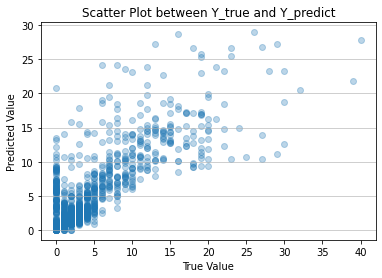

In [13]:
model_perceptron = Multilayer_Perceptron()
model_perceptron.fit(train_dataset, Ytrain, epochs=10, batch_size=128)

scatter_plot(test_dataset, Ytest, model_perceptron)

2.2.3 Ridge Regression

In [10]:
from sklearn.model_selection import GridSearchCV

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished
C:\Users\jiaen\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.92883e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\jiaen\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.92883e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\jiaen\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.61113e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\jiaen\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.11627e-17): result may n

RMSE of 3-fold cross-validation is:  [3.5436, 3.8516, 2.1581]

Correlation Coefficient:  0.7418
Root Mean Squared Error:  3.9041
R2 score:  0.4192


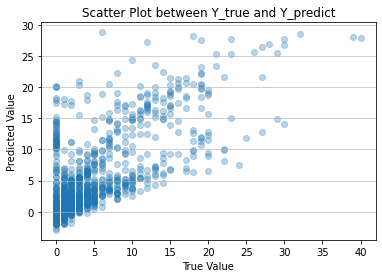

In [13]:
model_ridge = Ridge()
ridge_param = {'alpha': np.arange(0, 0.5, 0.05)}
ridge_grid_search = GridSearchCV(model_ridge, ridge_param, cv=KFold(n_splits=3), scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=5)
ridge_grid_search.fit(train_dataset, Ytrain)
model_ridge_ = Ridge(alpha=ridge_grid_search.best_params_['alpha']).fit(train_dataset, Ytrain)

rmse_ridge = [round(sqrt(i),4) for i in -cross_val_score(model_ridge_, train_dataset, Ytrain, cv=3, scoring='neg_mean_squared_error')]
print('RMSE of 3-fold cross-validation is: ', rmse_ridge)
print()

scatter_plot(test_dataset, Ytest, model_ridge_)

2.2.4 Support Vector Regression

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    7.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    7.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    8.5s finished


RMSE of 3-fold cross-validation is:  [4.7706, 5.0546, 4.6577]

Correlation Coefficient:  0.2868
Root Mean Squared Error:  5.5779
R2 score:  -0.1855


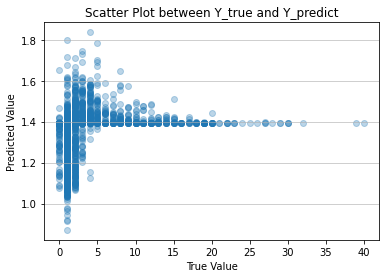

In [11]:
from sklearn.svm import SVR

model_svr = SVR()
svr_param = {'kernel': ['rbf'], 'C': [1e-3, 1e-2, 1e-1], 'gamma': [1e-3, 1e-2, 1e-1]}
svr_grid_search = GridSearchCV(model_svr, svr_param, cv=KFold(n_splits=3), scoring = 'neg_mean_squared_error',n_jobs=-1, verbose=5)
svr_grid_search.fit(train_dataset, Ytrain)
model_svr_ = SVR(kernel=svr_grid_search.best_params_['kernel'], C=svr_grid_search.best_params_['C'], gamma=svr_grid_search.best_params_['gamma']).fit(train_dataset, Ytrain)

rmse_svr = [round(sqrt(i),4) for i in -cross_val_score(model_svr_, train_dataset, Ytrain, cv=3, scoring='neg_mean_squared_error')]
print('RMSE of 3-fold cross-validation is: ', rmse_svr)
print()

scatter_plot(test_dataset, Ytest, model_svr_)

# **Question3**
**Develop an architecture of neural network that takes an image directly as input and produces a count as the output.**


In [12]:
from sklearn.model_selection import cross_val_score, KFold
from tensorflow import keras
from keras.optimizers import Adagrad
from keras import backend
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [13]:
# input image dimensions
img_rows, img_cols = 299, 299

Xtrain_cnn = Xtrain.astype('float32')  # Convert the pixel into block type
Xtest_cnn = Xtest.astype('float32')
Xtrain_cnn /= 255
Xtest_cnn /= 255

In [25]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def cnn():
    model_cnn = Sequential()
    model_cnn.add(Conv2D(12, kernel_size=(3,3), activation='linear', input_shape=(299,299,3)))  # Design a filter to convolve the images
    model_cnn.add(Conv2D(24, (3,3), activation='linear'))  # Design another filter
    model_cnn.add(MaxPooling2D(pool_size = (3,3)))  #Reduce the dimensions of the output 
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Flatten())  # Convert an image to a vector
    model_cnn.add(Dense(units=24, activation='linear'))
    model_cnn.add(Dropout(0.3))
    model_cnn.add(Dense(1, activation='linear'))  # Output the predicted counts

    model_cnn.compile(loss = 'mse', optimizer = 'adam', metrics = [rmse])
    
    return model_cnn

model_cnn = KerasRegressor(build_fn=cnn, epochs=3, batch_size=64)

In [20]:
rmse_cnn = [sqrt(i) for i in -cross_val_score(model_cnn, Xtrain_cnn, Ytrain, cv=3)]
print('RMSE of cross-validation is: ', rmse_cnn)

Epoch 1/3
3894/3894 [==============================] - ETA: 2:42 - loss: 39.5540 - rmse: 3.234 - ETA: 2:10 - loss: 40.5270 - rmse: 3.232 - ETA: 1:57 - loss: 34.6623 - rmse: 2.990 - ETA: 1:50 - loss: 31.3169 - rmse: 2.785 - ETA: 1:46 - loss: 29.0419 - rmse: 2.667 - ETA: 1:43 - loss: 25.5896 - rmse: 2.508 - ETA: 1:39 - loss: 24.7202 - rmse: 2.479 - ETA: 1:34 - loss: 24.8570 - rmse: 2.524 - ETA: 1:29 - loss: 24.8125 - rmse: 2.523 - ETA: 1:23 - loss: 25.3024 - rmse: 2.552 - ETA: 1:19 - loss: 25.6146 - rmse: 2.574 - ETA: 1:14 - loss: 25.9972 - rmse: 2.590 - ETA: 1:10 - loss: 25.4493 - rmse: 2.558 - ETA: 1:06 - loss: 24.6220 - rmse: 2.522 - ETA: 1:01 - loss: 24.8752 - rmse: 2.557 - ETA: 57s - loss: 25.2639 - rmse: 2.564 - ETA: 54s - loss: 25.3069 - rmse: 2.56 - ETA: 50s - loss: 25.3677 - rmse: 2.56 - ETA: 46s - loss: 25.3422 - rmse: 2.56 - ETA: 42s - loss: 24.7393 - rmse: 2.52 - ETA: 38s - loss: 26.5422 - rmse: 2.55 - ETA: 34s - loss: 26.6519 - rmse: 2.56 - ETA: 30s - loss: 26.4117 - rmse: 2

Epoch 1/6
5841/5841 [==============================] - ETA: 2:41 - loss: 67.9760 - rmse: 4.887 - ETA: 2:34 - loss: 75606.7067 - rmse: 193.14 - ETA: 2:30 - loss: 54726.9718 - rmse: 165.84 - ETA: 2:28 - loss: 43466.2118 - rmse: 148.56 - ETA: 2:26 - loss: 42241.2014 - rmse: 156.93 - ETA: 2:24 - loss: 40123.0299 - rmse: 158.79 - ETA: 2:21 - loss: 35590.4713 - rmse: 148.90 - ETA: 2:19 - loss: 31275.5130 - rmse: 134.25 - ETA: 2:18 - loss: 29956.9964 - rmse: 134.53 - ETA: 2:16 - loss: 29967.6139 - rmse: 138.18 - ETA: 2:14 - loss: 28497.3521 - rmse: 136.12 - ETA: 2:12 - loss: 26220.8537 - rmse: 127.54 - ETA: 2:11 - loss: 24370.0385 - rmse: 121.23 - ETA: 2:09 - loss: 23267.6742 - rmse: 119.15 - ETA: 2:07 - loss: 22724.3454 - rmse: 119.26 - ETA: 2:05 - loss: 21985.7063 - rmse: 118.23 - ETA: 2:04 - loss: 21016.0658 - rmse: 115.53 - ETA: 2:02 - loss: 19904.2977 - rmse: 110.80 - ETA: 2:02 - loss: 18869.4532 - rmse: 105.75 - ETA: 2:01 - loss: 18045.2595 - rmse: 102.83 - ETA: 2:00 - loss: 17431.0058 

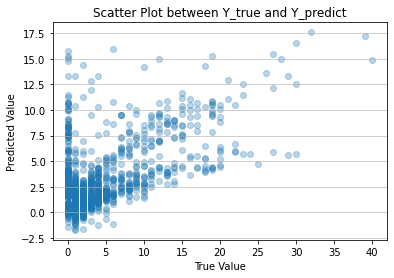

In [26]:
model_cnn = cnn()
model_cnn.fit(Xtrain_cnn, Ytrain, epochs=6, batch_size=64)

scatter_plot(Xtest_cnn, Ytest, model_cnn)